In [1]:
import numpy as np #importing packages
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# mnist dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchvision import transforms

from dataset_tools import OwnDataset
from plotting import show_img, loss_plots, plot_random_images, plot_image_comparison
from collections import defaultdict


cuda = torch.cuda.is_available()
print(cuda)

False


In [2]:
tf = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    # transforms.Lambda(lambda x: x.view(-1)) # notice that we dont flatten when we are going to use CNN
])


In [16]:
data = pd.read_parquet('metadata.parquet') # read parquet file

data["moa"].value_counts() # count the number of unique values in the column


DMSO                         276360
Microtubule stabilizers       89157
Aurora kinase inhibitors      16810
DNA damage                    16582
Microtubule destabilizers     15178
Epithelial                    14955
Eg5 inhibitors                12525
Kinase inhibitors             11622
Protein synthesis              9715
Actin disruptors               7491
Protein degradation            6589
DNA replication                5976
Cholesterol-lowering           5436
Name: moa, dtype: int64

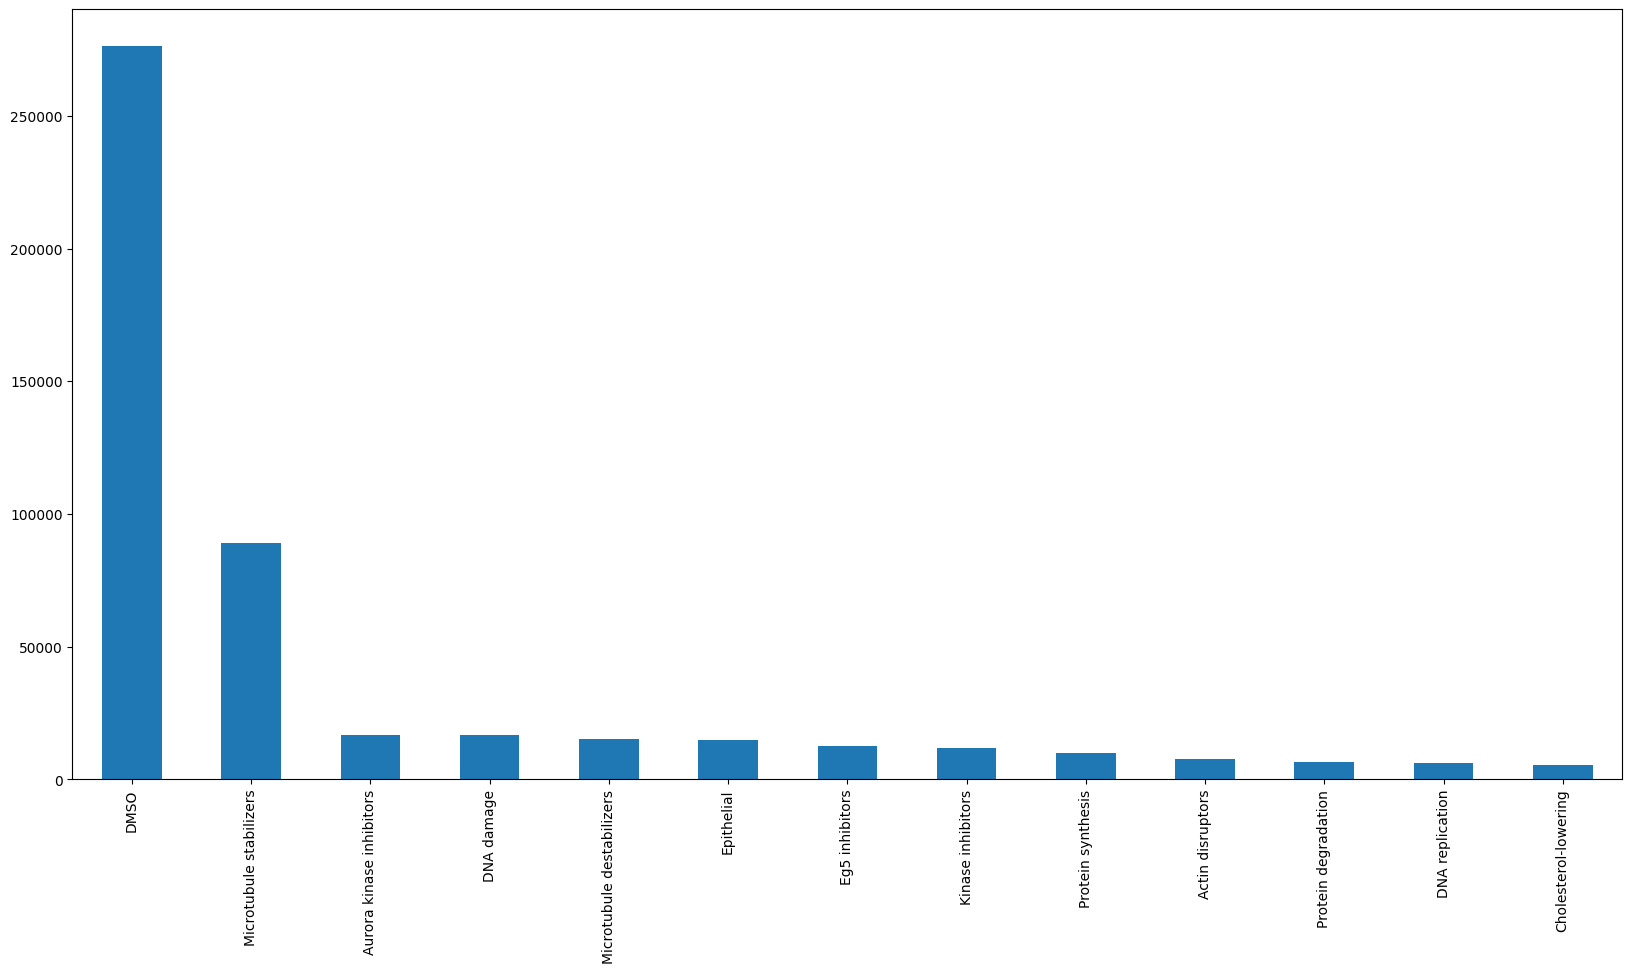

In [18]:
# we want to make a bar plot of this 

data["moa"].value_counts().plot(kind='bar', figsize=(20,10))
plt.show()


In [15]:
# we want to convert the moa column to a one hot encoded vector
moa = data["moa"].values
moa = np.unique(moa)
moa_dict = {moa[i]: i for i in range(len(moa))}
moa_dict_reverse = {i: moa[i] for i in range(len(moa))}
data["moa"] = data["moa"].apply(lambda x: moa_dict[x])

data["moa"].value_counts()

3     276360
10     89157
1      16810
4      16582
9      15178
7      14955
6      12525
8      11622
12      9715
0       7491
11      6589
5       5976
2       5436
Name: moa, dtype: int64